# 강화 학습

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
import matplotlib.animation as animation
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices("GPU"):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# 부드러운 애니메이션을 위해
mpl.rc("animation", html="jshtml")

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장 " + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

2023-05-09 12:04:58.084224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 12:05:01.307121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-09 12:05:01.491781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-09 12:05:01.492000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

## OpenAI 짐

이 노트북은 강화학습 알고리즘을 개발하고 평가하는 훌륭한 도구인 [OpenAI 짐(gymnasium)](https://gymnasium.farama.org/)을 사용한다. 학습 에이전트가 상호작용하기 위한 환경을 많이 제공한다. 먼저 `gymnasium`을 임포트한다:

In [2]:
import gymnasium

가능한 환경 목록을 확인한다:

In [3]:
gymnasium.envs.registry.values()

dict_values([EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=Fals

Cart-Pole은 매우 간단한 환경으로 왼쪽과 오른쪽으로 움직이는 카트와 그 위에 수직으로 놓여 있는 막대로 구성된다. 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여 막대가 바로 서 있도록 만들어야 한다.

In [4]:
env = gymnasium.make("CartPole-v1", render_mode="rgb_array")

`reset()` 메서드를 호출해 환경을 초기화한다. 이 메서드는 관측을 반환한다:

In [5]:
obs, _ = env.reset(seed=42)

관측은 환경에 따라 다르다. 이 경우 4개의 실수로 구성된 1D 넘파이 배열이다. 카트의 수평 위치, 속도, 막대의 각도(0=수직), 각속도를 나타낸다.

In [6]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

환경은 `render()` 메서드를 호출하여 시각화할 수 있다. 그리고 렌더링 모드(환경에 따른 렌더링 옵션)를 선택할 수 있다.

**경고**: (Cart-Pole을 포함해) 일부 환경은 화면 접근 권한이 필요하다. `render_mode="rgb_array"`로 지정하더라도 별도의 윈도우를 연다. 일반적으로 이 윈도우를 무시할 수 있다. 하지만 주피터를 백엔드(headless) 서버로 실행한다면 예외가 발생한다. 이를 피하는 한 가지 방법은 [Xvfb](http://en.wikipedia.org/wiki/Xvfb) 같은 가짜 X 서버를 설치하는 것이다. 데비안이나 우분투에서는 다음과 같이 설치한다:

```bash
$ apt update
$ apt install -y xvfb
```

그다음 `xvfb-run` 명령으로 주피터를 실행한다:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

또는 Xvfb를 감싼 [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) 파이썬 라이브러리를 설치할 수 있다:

```bash
%pip install -U pyvirtualdisplay
```

그다음 다음 코드를 실행한다:

In [7]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [9]:
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

이 예에서는 `render_mode="rgb_array"`로 지정해 환경 이미지를 넘파이 배열로 받는다:

In [10]:
img = env.render()
img.shape

(400, 600, 3)

In [11]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

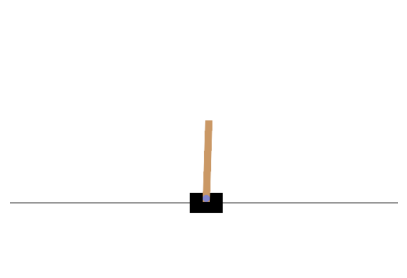

In [12]:
plot_environment(env)
plt.show()

환경과 상호작용하는 방법을 알아 본다. 에이전트는 "행동 공간"(가능한 행동의 집합)에서 하나의 행동을 선택해야 한다. 이 환경의 행동 공간을 다음처럼 확인한다:

In [13]:
env.action_space

Discrete(2)

단 두 개의 행동이 가능하다: 왼쪽 또는 오른쪽으로 가속한다.

막대가 오른쪽으로 기울어져 있기 때문에(`obs[2] > 0`), 카트를 오른쪽으로 가속한다:

In [14]:
action = 1  # 오른쪽으로 가속
obs, reward, terminated, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

이제 카트가 오른쪽으로 움직였다(`obs[1] > 0`). 막대가 여전히 오른쪽으로 기울었다(`obs[2] > 0`). 하지만 각속도가 음수이므로(`obs[3] < 0`) 다음 스텝에서는 왼쪽으로 기울 것이다.

그림 저장 cart_pole_plot


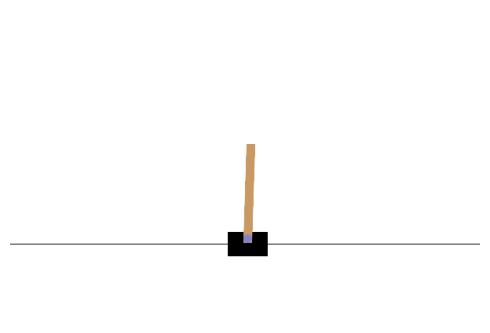

In [15]:
plot_environment(env)
save_fig("cart_pole_plot")

요청한 대로 실행된다!

환경은 이전 스텝에서 얼마나 많은 보상을 받는지 에이전트에게 알린다:

In [16]:
reward

1.0

게임이 끝나면 환경은 `terminated = True`나 `truncated = True`를 반환한다:

In [17]:
terminated, truncated

(False, False)

마지막으로 `info`는 훈련이나 디버깅에 유용한 추가적인 정보를 담은 환경에 특화된 딕셔너리이다. 예를 들어 일부 게임에서는 얼마나 많은 에이전트의 생명이 몇 개가 남아 있는지 나타낸다.

In [18]:
info

{}

환경이 재설정된 순간부터 종료될 때까지 스텝 시퀀스를 "에피소드"라고 한다. 에피소드 끝에서(즉, `step()`이 `terminated = True`나 `truncated = True`를 반환할 때), 계속하기 전에 환경을 재설정해야 한다.

In [19]:
if terminated or truncated:
    obs = env.reset()

그럼 어떻게 막대를 똑바로 유지할 수 있을까? 이를 위해 정책을 정의해야 한다. 에이전트가 매 스텝마다 행동을 선택하기 위해 사용할 전략이다. 어떤 행동을 선택할지 결정하기 위해 지난 행동과 관측을 모두 사용할 수 있다.

**간단한 하드 코딩 정책**

간단한 정책을 하드 코딩한다. 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 움직이고 오른쪽으로 기울어지면 반대로 움직인다. 어떻게 작동하는지 확인한다:

In [20]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_rewards = 0
    obs, _ = env.reset()
    while True:
        action = basic_policy(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        episode_rewards += reward
        if (terminated or truncated):
            break
    totals.append(episode_rewards)

In [21]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.18, 9.015963620157304, 24.0, 72.0)

예상대로 이 전략은 너무 단순하다. 최대로 막대를 유지한 스텝 횟수가 72이다. 이 환경은 에이전트가 막대를 200 스텝 이상 유지해야 해결된 것으로 간주한다.

하나의 에피소드를 시각화한다:

In [22]:
frames = []
obs, _ = env.reset()
while True:
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)
    obs, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break

애니메이션을 출력합니다:

In [23]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig, update_scene, len(frames), fargs=(frames, patch), repeat=repeat, interval=interval
    )
    plt.close()
    return anim

In [24]:
plot_animation(frames)

확실히 이 방법은 불안정해서 약간 흔들리면 막대가 너무 기울어져 게임이 끝난다. 이 보다는 더 똑똑한 전략이 필요하다!

## 신경망 정책

관측을 입력으로 받고 각 관측에 대해 선택할 행동의 확률을 출력하는 신경망을 만든다. 행동을 선택하기 위해 신경망은 각 행동의 확률을 추정한다. 이 추정된 확률에 따라 랜덤하게 행동을 선택한다. Cart-Pole 환경의 경우 두 개의 가능한 행동이 있다(왼쪽과 오른쪽). 따라서 하나의 출력 뉴런만 있으면 된다. 이 뉴런은 행동 0(왼쪽)의 확률 `p`를 출력한다. 물론 행동 1(오른쪽)의 확률은 `1 - p`이다.

In [25]:
keras.backend.clear_session()
n_inputs = 4  # == env.observation_space.shape[0]
model = keras.Sequential(
    [
        keras.layers.Dense(5, "elu", input_shape=[n_inputs]),
        keras.layers.Dense(1, "sigmoid")
    ]
)

2023-05-09 12:06:59.419297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-09 12:06:59.419591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-09 12:06:59.419788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-09 12:07:00.895198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-09 12:07:00.895529: I tensorflow/compile

이 환경에서는 지난 행동과 관측을 무시한다. 각 관측이 완전한 환경의 상태를 담고 있기 때문이다. 은닉 상태가 있다면 환경의 은닉 상태를 추정하기 위해 지난 행동과 관측을 고려한다. 예를 들어, 이 환경이 카트의 위치만 제공하고 속도를 알려 주지 않는다면, 현재 속도를 추정하기 위해 현재 관측 뿐만 아니라 지난 관측도 고려한다. 또 다른 예는 관측에 잡음이 있는 경우이다. 가장 가능성 있는 현재 상태를 추정하기 위해 지난 몇 개의 관측을 사용한다. 이 문제는 매우 간단하다. 현재 관측에 잡음이 없고 환경의 모든 상태가 담긴다.

정책 네트워크가 출력한 확률 중에서 가장 높은 확률을 가진 행동을 선택하지 않고 랜덤한 행동을 선택하는 이유가 궁금할지 모른다. 이 방법은 에이전트가 새로운 행동을 탐험하는 것과 잘 동작하는 행동을 활용하는 것 사이에 밸런스를 찾도록 한다. 비유를 들겠다. 한 음식점에 처음 방문했다고 가정한다. 모든 음식에 대한 선호도가 동일하다면 랜덤하게 하나를 선택한다. 이 음식이 좋다고 느낀다면 다음 번에 이 음식을 주문할 확률을 높일 수 있다. 하지만 이 확률을 100%로 높여서는 안 된다. 그렇지 않으면 다른 음식을 시도해 볼 수 없다. 어쩌면 다른 음식이 이번에 먹은 것보다 훨씬 더 좋을 수도 있다.

모델을 실행하여 한 에피소드를 플레이하고 애니메이션을 위한 프레임을 반환하는 함수를 작성한다:

In [26]:
def render_policy_net(model):
    frames = []
    env = gymnasium.make("CartPole-v1", render_mode="rgb_array")
    obs, _ = env.reset()
    while True:
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    return frames

랜덤하게 초기화된 정책 네트워크가 얼마나 잘 수행하는지 확인한다:

In [27]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 14ms/step


아주 나쁘다. 이 신경망은 더 배워야 한다. 먼저 앞에서 사용한 기본적인 정책을 학습할 수 있는지 확인한다. 막대가 왼쪽으로 기울면 왼쪽으로 움직이고, 오른쪽으로 기울면 오른쪽으로 움직이도록 한다.

같은 신경망으로 동시에 50개의 다른 환경을 플레이한다(이렇게 하면 각 스텝마다 다양한 훈련 배치를 얻는다). 그리고 5000번 반복 동안에 훈련한다. 게임이 종료되면 환경을 재설정한다. 사용자 정의 훈련 루프를 사용하여 모델을 훈련하기 때문에 훈련 스텝마다 환경에 앞서 예측을 쉽게 만들 수 있다.

In [28]:
n_environments = 50
n_iterations = 5000
envs = [gymnasium.make("CartPole-v1") for _ in range(n_environments)]
observations = [env.reset()[0] for env in envs]
optimizer = keras.optimizers.experimental.RMSprop()
loss_fn = keras.metrics.binary_crossentropy
for iteration in range(n_iterations):
    # angle < 0이면 proba(left) = 1., 그렇지 않으면 proba(left) = 0.이 된다.
    target_probas = np.array(
        [([1.] if obs[2] < 0 else [0.]) for obs in observations]
    )
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.math.reduce_mean(loss_fn(target_probas, left_probas))
    print(f"\rIteration: {iteration}, Loss: {loss.numpy():.3f}", end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (
        np.random.rand(n_environments, 1) > left_probas.numpy()
    ).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, _, terminated, truncated, _ = env.step(actions[env_index][0])
        observations[
            env_index
        ] = obs if not (terminated or truncated) else env.reset()[0]
for env in envs:
    env.close()

Iteration: 0, Loss: 0.686

2023-05-09 12:07:04.664907: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x20373340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-09 12:07:04.664954: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-05-09 12:07:05.554413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-09 12:07:08.115715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-09 12:07:08.450760: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-09 12:07:08.645434: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration: 4999, Loss: 0.093

In [29]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 14ms/step


정책을 잘 학습했다. 이제 스스로 더 나은 정책을 학습할 수 있는지 확인한다.

## 정책 그레이디언트

이 신경망을 훈련하려면 타깃 확률 `y`를 정의해야 한다. 행동이 좋으면 해당 확률을 증가시키고 반대로 나쁘면 감소시킨다. 하지만 행동이 좋은지 나쁜지 어떻게 알까? 대부분 행동의 효과가 지연되어 나타나기 때문에 한 에피소드에서 점수를 얻거나 잃을 때 어떤 행동이 이 결과에 기여했는지 명확하지 않다. 마지막 행동일까? 아니면 마지막에서 10번째 행동일까? 아니면 50 스텝 이전의 행동일까? 이를 _신용 할당 문제_ 라고 부른다.

_정책 그레이디언트_ 알고리즘은 이 문제를 해결하기 위해 먼저 여러 개의 에피소드를 플레이하고 그다음 좋은 에피소드에 있는 행동의 가능성을 조금 더 높이고, 나쁜 에피소드에 있는 행동의 가능성을 조금 낮춘다. 먼저 플레이해보고 다시 돌아가서 수행한 작업을 생각해 본다.

이 모델을 사용해 하나의 스텝을 플레이하는 함수를 만든다. 지금은 선택한 행동이 모두 좋다고 가정하고 손실과 그레이디언트를 계산한다(그레이디언트를 저장하고 나중에 행동이 좋은지 나쁜지에 따라 수정한다):

In [30]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.math.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, _ = env.step(int(action[0, 0].numpy()))
    return obs, reward, terminated, truncated, grads

`left_proba`가 높으면 `action`이 `False`가 될 가능성이 높다(0~1 사이에서 균등 분포로 난수를 샘플링하면 `left_proba`보다 높지 않을 가능성이 높기 때문에). 그리고 `False`를 숫자로 바꾸면 0이므로 `y_target`은 1 - 0 = 1이다. 다른 말로 하면 타깃을 1로 지정하는 것은 왼쪽일 확률을 100%로 가정한다는 의미이다(따라서 올바른 행동을 선택했다).

이제 `play_one_step()` 함수를 사용해 여러 개의 에피소드를 플레이하고 에피소드와 스텝마다 모든 보상과 그레이디언트를 반환하는 또 다른 함수를 만든다:

In [31]:
def play_multiple_episodes(env, n_episodes, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        while True:
            obs, reward, terminated, truncated, grads = play_one_step(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if terminated or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

정책 그레이디언트 알고리즘은 모델을 사용해 여러 번 에피소드를 플레이한다(예를 들어 10번). 그다음 모든 보상을 할인하고 정규화한다. 이를 위한 함수를 만들어 본다. 첫 번째 함수는 할인된 보상을 계산한다. 두 번째 함수는 여러 에피소드에 걸쳐 할인된 보상을 정규화한다.

In [32]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [
        discount_rewards(rewards, discount_rate) for rewards in all_rewards
    ]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

3개의 행동을 수행하고 각 행동의 보상이 10, 0, -50이라고 가정해 본다. 80%의 할인 계수를 사용하면 세 번째 행동은 -50(마지막 보상의 100%)를 받지만 두 번째 행동은 -40(마지막 보상의 80%)만 받는다. 그리고 첫 번째 행동은 -40의 80%(-32)에 첫 번째 보상(+10)의 100%를 받는다. 따라서 할인된 보상의 합은 -22가 된다:

In [33]:
discount_rewards([10, 0, -50], .8)

array([-22, -40, -50])

전체 에피소드에 대해 모든 할인된 보상을 정규화하기 위해 전체 할인된 보상의 평균과 표준 편차를 계산한다. 그리고 할인된 보상에서 평균을 빼고 표준 편차를 나눈다:

In [34]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [116]:
n_iterations = 21  # 150 / 7
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [117]:
optimizer = keras.optimizers.Adam(.01)
loss_fn = keras.metrics.binary_crossentropy

In [118]:
keras.backend.clear_session()
model = keras.Sequential(
    [
        keras.layers.Dense(5, "elu", input_shape=[4]),
        keras.layers.Dense(1, "sigmoid")
    ]
)

In [119]:
env = gymnasium.make("CartPole-v1")
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, model, loss_fn
    )
    total_rewards = sum(map(sum, all_rewards))
    print(
        f"\rIteration: {iteration}, mean rewards: {total_rewards / n_episodes_per_update:.1f}", end=""
    )
    all_final_rewards = discount_and_normalize_rewards(
        all_rewards, discount_rate
    )
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.math.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index] for episode_index, final_rewards in enumerate(all_final_rewards) for step, final_reward in enumerate(final_rewards)
            ],
            0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
env.close()

Iteration: 19, mean rewards: 46.0

In [120]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 14ms/step
